异常值检测（outlier）是一种数据挖掘过程，用于确定数据集中发现的异常值并确定其出现的详细信息。当前自动异常检测至关重要，因为大量数据无法手动标记异常值。 自动异常检测具有广泛的应用，例如信用卡欺诈检测，系统健康监测，故障检测以及传感器网络中的事件检测系统等。今天我们就通过使用python来实现异常值的自动检测系统的实战开发。我们将会使用以下技术来实现异常值检测:

* KMeans
* PCA
* IsolationForest
* SVM
* EllipticEnvelope

In [1]:
import pandas as pd
import numpy as np
import matplotlib.dates as md
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 
%matplotlib inline

# 数据

我们的数据kaggle你可以在这里<a href="https://www.kaggle.com/c/expedia-personalized-sort/data">下载</a>。Expedia是全球最大的在线旅行社（OTA,类似我们的携程网），它每天为数百万旅行购物者提供搜索服务其中包括用户在Expedia网站上搜索酒店的相关信息,如国家，地区，房型，价格，入住天数，入住时间等信息。  

我们想通过这个数据集来检测其中价格的异常值。由于Expedia提供的数据集非常大,为了能很好的演示我们的异常值检测功能，我们将从Expedia数据集中过滤出一个子集，该子集只包含用户查询的酒店标间(srch_room_count=1)和酒店所在地为美国(visitor_location_country_id=219)的信息。字段的含义如下:

* prop_id：酒店Id
* datetime: 用户查询的时间
* price_usd：价格(美元)
* srch_booking_window:从查询日期开始的酒店住宿天数
* srch_saturday_night_bool：如果住宿从周四晚上开始，小于等于4个晚上(必须包含周六晚上)则为1，否则为0  

 我们会看到同一家酒店,不同的住宿天数，是否包含周六晚，都会导致标间(单间)价格的不同,我们将从中找出价格的异常值

In [2]:
# df = pd.read_csv('./data/expedia_train.csv')
df = pd.read_csv('./data/expedia_train1.csv')
#过滤Id为104517的酒店
df = df.loc[df['prop_id'] == 104517]
#过滤标间
df = df.loc[df['srch_room_count'] == 1]
#219表示美国
df = df.loc[df['visitor_location_country_id'] == 219]
df = df[['date_time', 'price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
df.head(10)

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool
2,2013-03-14 11:27:28,206.0,99,1
4,2013-01-03 20:48:24,186.0,6,0
5,2013-01-19 16:51:27,61.0,1,0
6,2013-01-26 11:34:23,72.0,116,0
7,2013-04-29 09:39:50,246.0,245,0
8,2013-03-25 19:43:44,52.0,7,0
12,2013-05-19 19:52:42,68.0,42,0
14,2012-11-14 17:18:51,46.0,4,0
15,2013-01-10 19:22:49,50.0,46,0
16,2013-03-27 14:49:27,122.0,100,1


我们看一下数据集元数据信息:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3049 entries, 2 to 4732
Data columns (total 4 columns):
date_time                   3049 non-null object
price_usd                   3049 non-null float64
srch_booking_window         3049 non-null int64
srch_saturday_night_bool    3049 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 119.1+ KB


我们发现变量date_time的类型不是datetime类型，这会使我们在做可视化的时候出现问题，所以我们要将date_tiem的类型设置为datetime型，接下来我们主要目的是发现价格(price_usd)的异常值,所以我们首先看一下价格的分布情况:

count    3049.000000
mean      112.939023
std       113.374049
min         0.120000
25%        67.000000
50%       100.000000
75%       141.000000
max      5584.000000
Name: price_usd, dtype: float64


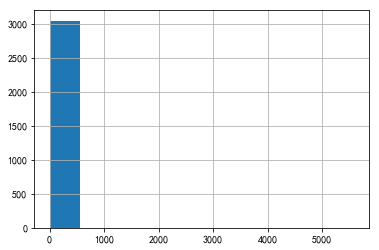

In [4]:
#将date_time的类型设置为datetime
df['date_time'] = pd.to_datetime(df['date_time'])
df = df.sort_values('date_time')
print(df['price_usd'].describe())
df['price_usd'].hist()

我们发现价格的均值是112，但是最大值却是5584. 这个一个极端的最大值。似乎所有价格数据都小于500，只有一个极端最大值5584。为了我们在后面能找到更多不是极端的异常值，我们先删除这个极端最大值。

count    3048.000000
mean      111.144055
std        55.055161
min         0.120000
25%        67.000000
50%       100.000000
75%       141.000000
max       536.000000
Name: price_usd, dtype: float64


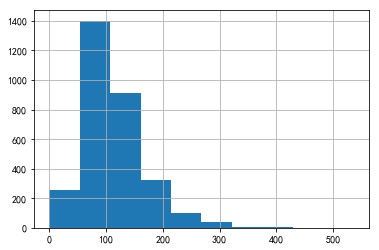

In [5]:
df = df.loc[df['price_usd'] < 5584]
print(df['price_usd'].describe())
df['price_usd'].hist()

删除价格的极端最大值以后,价格分布基本趋于正常(略微右偏)。

# 时间序列可视化

下面我们根据时间对价格进行可视化。

Text(0, 0.5, '价格(美元)')

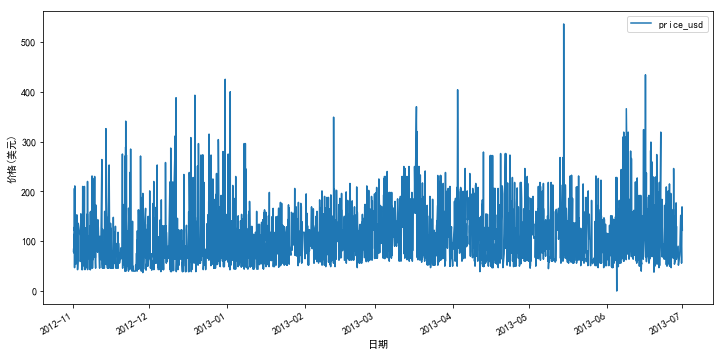

In [6]:
df.plot(x='date_time', y='price_usd', figsize=(12,6))
plt.xlabel('日期')
plt.ylabel('价格(美元)')

In [7]:
df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool
1905,2012-11-01 02:48:30,84.0,19,0
32,2012-11-01 03:06:43,78.0,16,1
1624,2012-11-01 09:04:18,114.0,56,1
2486,2012-11-01 09:11:03,76.0,56,1
3375,2012-11-01 10:15:25,128.0,0,1


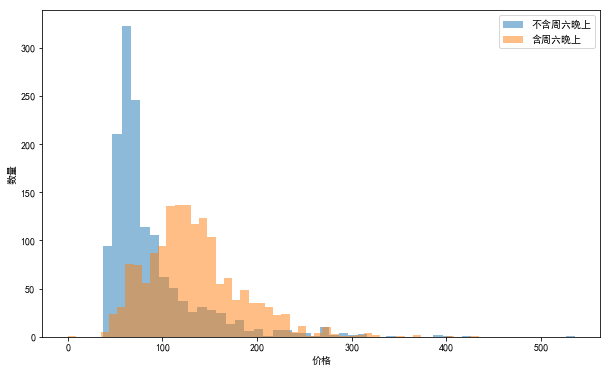

In [8]:
a = df.loc[df['srch_saturday_night_bool'] == 0, 'price_usd']
b = df.loc[df['srch_saturday_night_bool'] == 1, 'price_usd']
plt.figure(figsize=(10, 6))
plt.hist(a, bins = 50, alpha=0.5, label='不含周六晚上')
plt.hist(b, bins = 50, alpha=0.5, label='含周六晚上')
plt.legend(loc='upper right')
plt.xlabel('价格')
plt.ylabel('数量')
plt.show();

从上面的直方图可知含周六晚上的(srch_saturday_night_bool=1)的价格均值要大于不含周六晚上的(srch_saturday_night_bool=1)价格均值。含周末的房价略高一些，这应该是合理的。

In [9]:
df['srch_saturday_night_bool'].value_counts()

1    1599
0    1449
Name: srch_saturday_night_bool, dtype: int64

# 基于聚类的异常检测

k-means是一种广泛使用的聚类算法。 它创建了k个具有相似特性的数据组。 不属于这些组的数据实例可能会被标记为异常。 在我们开始k-means聚类之前，我们使用elbow方法来确定最佳聚类数量。

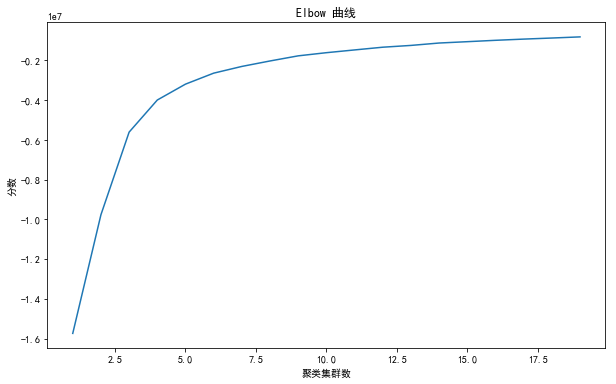

In [10]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('聚类集群数')
plt.ylabel('分数')
plt.title('Elbow 曲线')
plt.show()

为了找出合理的距离中心数，我们尝试尽可能多的聚类中心数（从1个到20个聚类中心），然后我们画出Elbow曲线，通过观察Elbow曲线,我们发现当我们的聚类中心数量增加到10个以上时Elbow曲线趋于收敛，因此我们大致可以将聚类中心数定为10.

下面我们将K-means算法的n_clusters设置为10,然后我们将数据进行3D可视化。

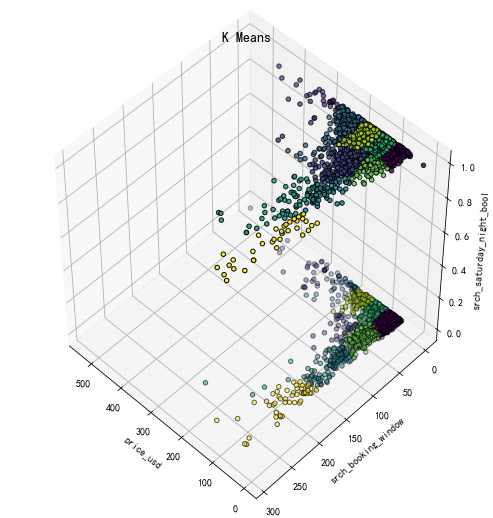

In [11]:
X = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=10)
km.fit(X)
km.predict(X)
labels = km.labels_

fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("price_usd")
ax.set_ylabel("srch_booking_window")
ax.set_zlabel("srch_saturday_night_bool")
plt.title("K Means", fontsize=14);

接下来我们要确定需要保留数据中的哪些主要成分(特征)

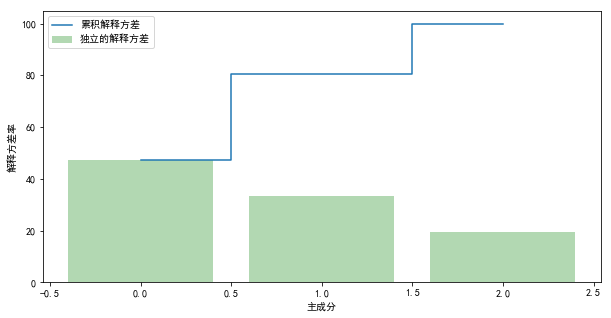

In [12]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = data.values

#标准化处理,均值为0,标准差为1
X_std = StandardScaler().fit_transform(X)
mean_vec = np.mean(X_std, axis=0)
#计算协方差
cov_mat = np.cov(X_std.T)

#计算特征值和特征向量
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

#每个特征值对应一组特征向量
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)

#特征值求和
tot = sum(eig_vals)

#每个主要成分的解释方差
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] 
#累计的解释方差
cum_var_exp = np.cumsum(var_exp) 

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='独立的解释方差', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='累积解释方差')
plt.ylabel('解释方差率')
plt.xlabel('主成分')
plt.legend(loc='best')
plt.show();

我们首先对数据进行标准化处理(StandardScaler)，然后再计算特征变量之间的协方差矩阵,协方差矩阵反应了特征变量之间的相关性，如果两个特征变量之间的协方差为正则说明它们之间是正相关关系,如果为负则说明它们之间是负相关关系，如果为0则说明特征变量之间是相互独立的关系,不存在相关关系(有时候我们也会用相关系数矩阵来代替协方差矩阵)。然后在协方差矩阵的基础上又计算了协方差矩阵的特征值和特征向量，根据特征值计算出每个主成分(特征)的解释方差,以及累计解释方差，我们这样做的目的是为了下一步做主成分分析(PCA)挑选出特征变量中的主成分。我们挑选前2个主成分，因为它们的累计解释方差为80%。

从上图可知我们的三个主成分,第一个主成分(特征)解释了将近50%的方差变化,第二个主成分解释了近30%的方差变化,那么前2个主成分解释了近80%的方差。因此接下来我们将使用PCA算法进行降维并将设置参数n_components=2。

In [13]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = data.values

#标准化处理,均值为0,标准差为1
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)

#将特征维度降到2
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# 降维后将2个新特征进行标准化处理
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [14]:
# #calculate with different number of centroids to see the loss plot (elbow method)
# n_cluster = range(1, 20)
# kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
# scores = [kmeans[i].score(data) for i in range(len(kmeans))]

# fig, ax = plt.subplots(figsize=(10,6))
# ax.plot(n_cluster, scores)
# plt.xlabel('Number of Clusters')
# plt.ylabel('Score')
# plt.show()

In [15]:
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
df['cluster'] = kmeans[9].predict(data)
df.index = data.index
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
# df['cluster'].value_counts()
df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool,cluster,principal_feature1,principal_feature2
0,2012-11-01 02:48:30,84.0,19,0,1,-0.889864,-0.521900
1,2012-11-01 03:06:43,78.0,16,1,5,0.230566,-0.272218
2,2012-11-01 09:04:18,114.0,56,1,2,0.567439,0.546642
3,2012-11-01 09:11:03,76.0,56,1,2,0.155659,0.581776
4,2012-11-01 10:15:25,128.0,0,1,9,0.793675,-0.659305


基于聚类的异常检测中的假设是，如果我们对数据进行聚类，则正常数据将属于聚类，而异常将不属于任何聚类或属于小聚类。 我们使用以下步骤来查找和可视化异常值。

* 计算每个数据点与其最近的聚类中心之间的距离。 最大的距离被认为是异常的。
* 设置一个异常值的比例outliers_fraction为1%,这样设置是因为在标准正太分布的情况下（N(0,1)）我们一般认定3个标准差以外的数据为异常值,3个标准差以内的数据包含了数据集中99%以上的数据,所以剩下的1%的数据可以视为异常值。
* 根据异常值比例outliers_fraction，计算异常值的数量number_of_outliers
* 设置一个判定异常值的阈值threshold
* 通过阈值threshold来判定数据是否为异常值
* 对数据进行可视化(包含正常数据和异常数据)

In [16]:
# 计算每个数据点到其聚类中心的距离
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

#设置异常值比例
outliers_fraction = 0.01

# 得到每个点到取聚类中心的距离，我们设置了10个聚类中心，kmeans[9]表示有10个聚类中心的模型
distance = getDistanceByPoint(data, kmeans[9])

#根据异常值比例outliers_fraction计算异常值的数量
number_of_outliers = int(outliers_fraction*len(distance))

#设定异常值的阈值
threshold = distance.nlargest(number_of_outliers).min()

#根据阈值来判断是否为异常值
df['anomaly1'] = (distance >= threshold).astype(int)

d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


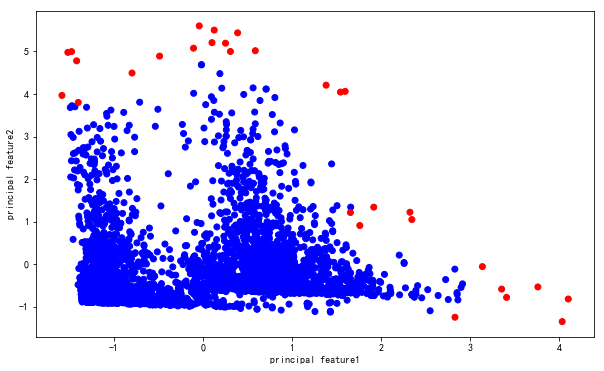

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

上图中红色的点即是被认定的异常值，它们大约占总数据量的1%。 

In [18]:
df.anomaly1.value_counts()

0    3018
1      30
Name: anomaly1, dtype: int64

In [19]:
df = df.sort_values('date_time')
a = df.loc[df['anomaly1'] == 1, ['date_time', 'price_usd']] #anomaly
a.head()

,date_time,price_usd
8,2012-11-01 14:20:52,211.0
96,2012-11-08 13:11:07,230.0
102,2012-11-08 23:23:16,225.0
203,2012-11-18 16:01:13,116.0
416,2012-12-07 08:32:50,126.0


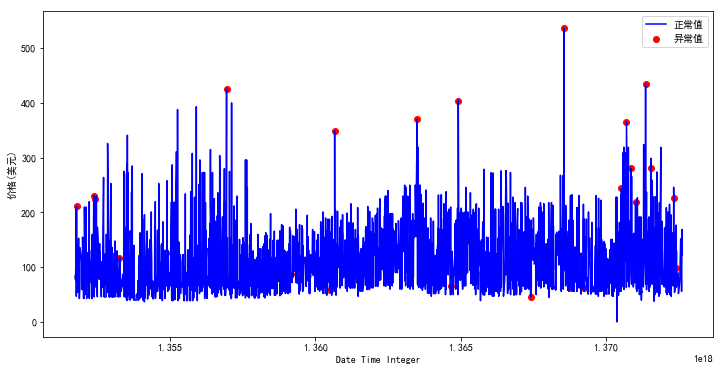

In [20]:
df = df.sort_values('date_time')
df['date_time_int'] = df.date_time.astype(np.int64)
fig, ax = plt.subplots(figsize=(12,6))

a = df.loc[df['anomaly1'] == 1, ['date_time_int', 'price_usd']] #anomaly

ax.plot(df['date_time_int'], df['price_usd'], color='blue', label='正常值')
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label='异常值')
plt.xlabel('Date Time Integer')
plt.ylabel('价格(美元)')
plt.legend()
plt.show()

从上图可知,经过PCA和KMeans计算出的异常值，它们的价格大多位于价格区间的最高点和最低点处，这应该是合理的。

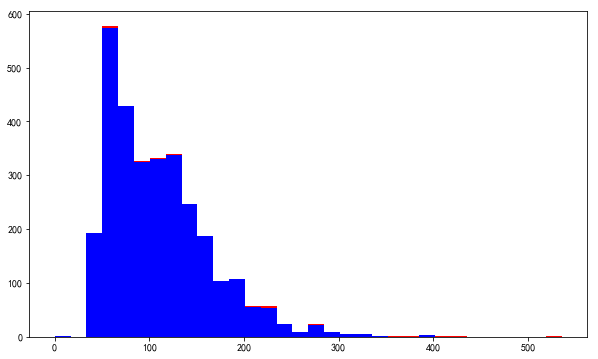

In [21]:
a = df.loc[df['anomaly1'] == 0, 'price_usd']
b = df.loc[df['anomaly1'] == 1, 'price_usd']

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show();

# 孤立森林(IsolationForest)异常检测
IsolationForest算法它是一种集成算法(类似于随机森林)主要用于挖掘异常(Anomaly)数据，或者说离群点挖掘，总之是在一大堆数据中，找出与其它数据的规律不太符合的数据。该算法不采样任何基于聚类或距离的方法，因此他和那些基于距离的的异常值检测算法有着根本上的不同，孤立森林认定异常值的原则是异常值是少数的和不同的数据。它通常用于网络安全中的攻击检测和流量异常等分析，金融机构则用于挖掘出欺诈行为。

* 当我们使用IsolationForest算法时需要设置一个异常值比例的参数contamination， 该参数的作用类似于之前的outliers_fraction。
* 使用 fit 方法对孤立森林模型进行训练
* 使用 predict 方法去发现数据中的异常值。返回1表示正常值，-1表示异常值。

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
d:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
d:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
d:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


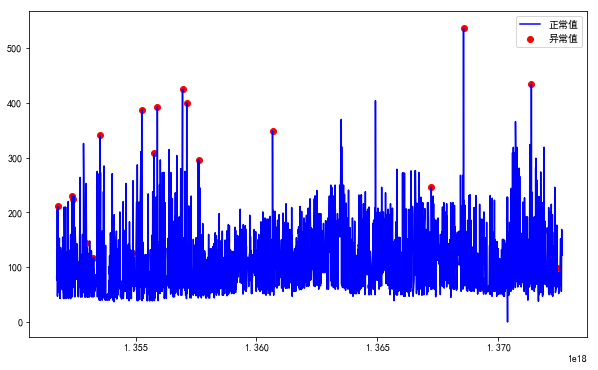

In [22]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# 训练孤立森林模型
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)

#返回1表示正常值，-1表示异常值
df['anomaly2'] = pd.Series(model.predict(data)) 

fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly2'] == -1, ['date_time_int', 'price_usd']] #异常值
ax.plot(df['date_time_int'], df['price_usd'], color='blue', label = '正常值')
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label = '异常值')
plt.legend()
plt.show();

从上图可知，使用孤立森林预测的异常值，它们的价格大多位于价格区间的最高点或最低点处。

In [23]:
df['anomaly2'].unique()

array([ 1, -1], dtype=int64)

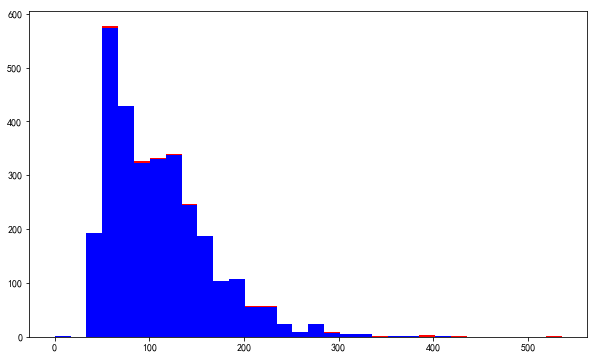

In [24]:
# visualisation of anomaly with avg price repartition
a = df.loc[df['anomaly2'] == 1, 'price_usd']
b = df.loc[df['anomaly2'] == -1, 'price_usd']

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show();

# 支持向量机(SVM)的异常检测
SVM通常应用于监督式学习，但OneClassSVM算法可用于将异常检测这样的无监督式学习，它学习一个用于异常检测的决策函数其主要功能将新数据分类为与训练集相似的正常值或不相似的异常值。

## OneClassSVM
OneClassSVM的思想来源于这篇<a href="http://users.cecs.anu.edu.au/~williams/papers/P126.pdf">论文</a>,SVM使用大边距的方法，它用于异常检测的主要思想是:将数据密度较高的区域分类为正，将数据密度较低的区域分类为负

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
d:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


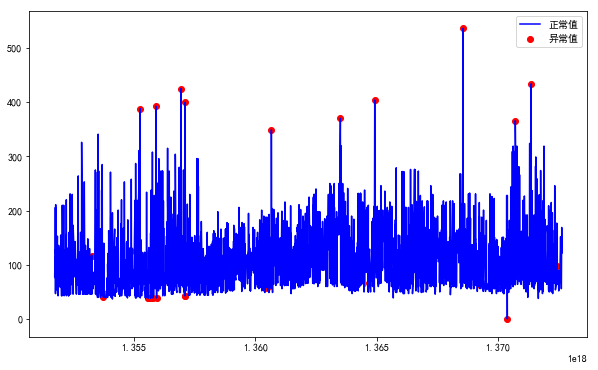

In [25]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# 训练 oneclassSVM 模型
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(data)
 
df['anomaly3'] = pd.Series(model.predict(data))
fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly3'] == -1, ['date_time_int', 'price_usd']] #anomaly

ax.plot(df['date_time_int'], df['price_usd'], color='blue', label ='正常值')
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label = '异常值')
plt.legend()
plt.show();

从上图可知，使用OneClassSVM预测的异常值，它们的价格大多位于价格区间的最高点或最低点处。

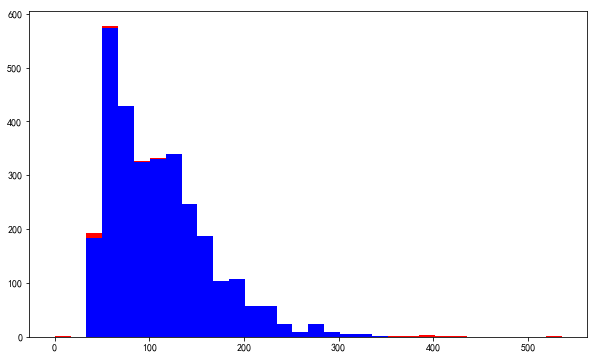

In [26]:
a = df.loc[df['anomaly3'] == 1, 'price_usd']
b = df.loc[df['anomaly3'] == -1, 'price_usd']

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show();

# 基于高斯概分布的异常检测

高斯分布也称为正态分布。 它可以被用来进行异常值检测，不过我们首先要假设我们的数据是正态分布的。 不过这个假设不能适应于所有数据集。但如果我们做了这种假设那么它将会有一种有效的方法来发现异常值。

Scikit-Learn的EllipticEnvelope模型，它在假设我们的数据是多元高斯分布的基础上计算出高斯分布的一些关键参数过程。过程大致如下:

根据前面定义的类别创建两个不同的数据集 ： search_Sat_night和Search_Non_Sat_night。
在每个类别应用EllipticEnvelope（高斯分布）。
我们设置contamination参数，它表示我们数据集中异常值的比例。
使用decision_function来计算给定数据的决策函数。 它等于移位的马氏距离(Mahalanobis distances)。 异常值的阈值为0，这确保了与其他异常值检测算法的兼容性。
使用predict 来预测数据是否为异常值(1 正常值, -1 异常值)

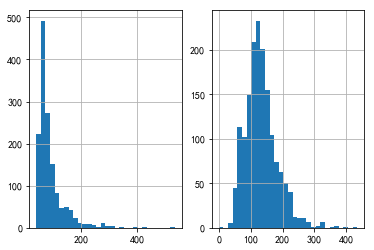

In [27]:
df_class0 = df.loc[df['srch_saturday_night_bool'] == 0, 'price_usd']
df_class1 = df.loc[df['srch_saturday_night_bool'] == 1, 'price_usd']

fig, axs = plt.subplots(1,2)
df_class0.hist(ax=axs[0], bins=30)
df_class1.hist(ax=axs[1], bins=30);

In [28]:
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

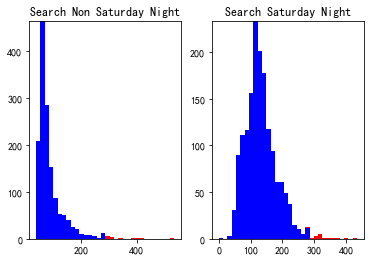

In [29]:
# plot the price repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'price_usd']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'price_usd']

a2 = df_class1.loc[df_class1['anomaly'] == 1, 'price_usd']
b2 = df_class1.loc[df_class1['anomaly'] == -1, 'price_usd']

fig, axs = plt.subplots(1,2)
axs[0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'])
axs[1].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'])
axs[0].set_title("Search Non Saturday Night")
axs[1].set_title("Search Saturday Night")
plt.show();

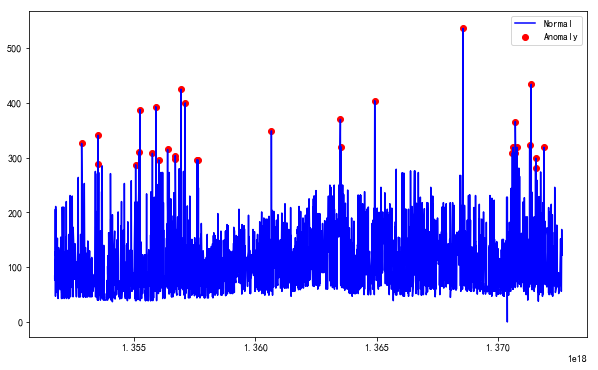

In [30]:
# add the data to the main 
df_class = pd.concat([df_class0, df_class1])
df['anomaly5'] = df_class['anomaly']
# df['anomaly5'] = np.array(df['anomaly22'] == -1).astype(int)
fig, ax = plt.subplots(figsize=(10, 6))
a = df.loc[df['anomaly5'] == -1, ('date_time_int', 'price_usd')] #anomaly
ax.plot(df['date_time_int'], df['price_usd'], color='blue', label='Normal')
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label='Anomaly')
plt.legend()
plt.show();

从上图可知，使用EllipticEnvelope预测的异常值，它们的价格大多位于价格区间的最高点处在最低点处没有出现异常值。

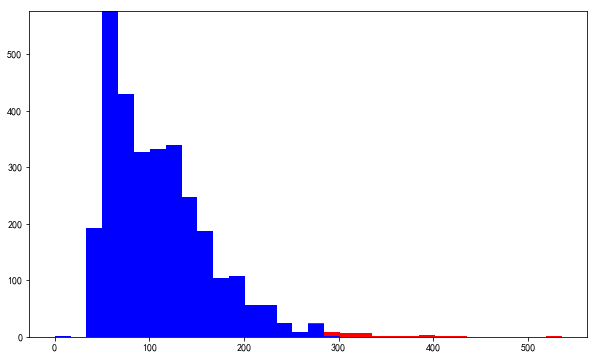

In [31]:
a = df.loc[df['anomaly5'] == 1, 'price_usd']
b = df.loc[df['anomaly5'] == -1, 'price_usd']

fig, axs = plt.subplots(figsize=(10, 6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show();

到目前为止，我们已经用四种不同的方法进行了价格异常检测。 因为我们的异常检测是无监督学习。 在构建模型之后，我们不知道他们的异常检测效果怎么样，因为我们没有办法可以对他们进行测试。 通常异常检测只有在实际的应用场景中才能测试出它的效果。

# 参考

* <a href="https://www.datascience.com/blog/python-anomaly-detection">Introduction to Anomaly Detection</a>
* <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html">sklearn.ensemble.IsolationForest</a>
* <a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html">sklearn.svm.OneClassSVM</a>
* <a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html">sklearn.covariance.EllipticEnvelope</a>
* <a href="https://www.kaggle.com/victorambonati/unsupervised-anomaly-detection">Unsupervised Anomaly Detection | kaggle</a>